In [1]:
import matplotlib.pyplot as plt
import math
import pandas as pd

import numpy as np
import datetime as dt
from scipy import stats
from datetime import datetime
import matplotlib.patches as mpatches
from statistics import mean, stdev
from math import sqrt
from itertools import combinations
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from collections import defaultdict
import warnings
import sklearn as skl
warnings.filterwarnings('ignore')
import ast
from numpy.random import randn
from numpy.random import seed
import re
from numpy import cov
pd.options.display.max_columns = None

In [8]:
df = pd.read_csv("./all_data.csv")
df['rq6_setup_ratio'] = df['# of Script Setup Steps']/(df['# of Script BR-Specific Steps']+df['# of Script Setup Steps']+df['# of Unlinked Script S2Rs'])
df['rq6_unlinked_ratio'] = df['# of Unlinked Script S2Rs']/(df['# of Script BR-Specific Steps']+df['# of Script Setup Steps']+df['# of Unlinked Script S2Rs'])
df['rq6_ratio'] = (df['# of Script Setup Steps']+df['# of Unlinked Script S2Rs'])/(df['# of Script BR-Specific Steps']+df['# of Script Setup Steps']+df['# of Unlinked Script S2Rs'])
df["Time between open and label"] = abs(pd.to_timedelta(df['Time between open and label']).dt.total_seconds()/(60*60))
df['rq5_s2r'] =df["# of S2Rs that Lead to Multiple GUI actions"]/df['# of Bug Report S2Rs']
c1 = ["value of additional info (number of S2Rs and whether they are setup steps or not, type of context, etc)"]
c2 = ["how is the information presented? (Image, text, annotated image, video, etc)"]
sfx = ['','.1','.2']
ac1 = []
ac2 = []
for i in c1:
    for j in sfx:
        ac1.append(i+j)
        
for i in c2:
    for j in sfx:
        ac2.append(i+j)
for i in range(len(ac1)):
    for index, row in df.iterrows():
        if type(row[ac1[i]]) == type('string'):
            if type(row[ac2[i]]) != type('string'):
                df.at[index, ac2[i]] = row[ac1[i]]
true_comments = []
true_timestamps = []
for index, row in df.iterrows():
    if type(row['Confirmation Timestamp']) == type('String'):
        true_comments.append(row['Comments Before Confirmation'])
        true_timestamps.append(abs((datetime.strptime(row['Time opened'], "%m/%d/%y %H:%M")-datetime.strptime(row['Confirmation Timestamp'], "%Y-%m-%dT%H:%M:%SZ"))).total_seconds()/(60*60))
    else:
        true_comments.append(row["num_comments_before_label_ALL"])
        true_timestamps.append(row['Time between open and label'])
df['true_time_b4_repro'] = true_timestamps
df['true_comments_before_label'] = true_comments
for index, row in df.iterrows():
    if row['S2R Annotated Text?'] == 1:
        l = ast.literal_eval(row['S2R Type (Image, Annotated Image, Text, Recording)'])
        l.append('annotated text')
        df.at[index,'S2R Type (Image, Annotated Image, Text, Recording)'] = str(l)
    if row['OB Annotated Text?'] == 1:
        l = ast.literal_eval(row['OB Type (Image, Annotated Image, Text, Recording)'])
        l.append('annotated text')
        df.at[index,'OB Type (Image, Annotated Image, Text, Recording)'] = str(l)

In [9]:
users = df[df['user or dev']=="USER"]
devs = df[df['user or dev']=="DEV"]
n = df[df['Confrimation Status']=="Explicitly Reproduced"]
nc = df[df['new_rq2_tag']!="crash"]

{'crash': 50, 'cosmetic': 56, 'output': 60, 'navigation': 14}
crash


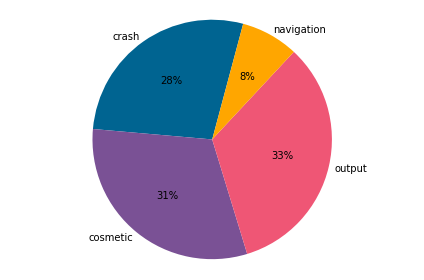

In [10]:
ratios = {
    "crash":0,
    "cosmetic":0,
    'output':0,
    'navigation':0
}
for i in df['new_rq2_tag']:
    ratios[i]+=1
labels = []
sizes = []

for x, y in ratios.items():
    labels.append(x)
    sizes.append(y)

plt.pie(sizes, labels=labels, autopct='%1.0f%%', labeldistance=1.05, colors=['#006491','#7a5195','#ef5675','#ffa600'],startangle=75)
plt.tight_layout()
plt.axis('equal')
plt.savefig('rq1_pie.eps', format='eps')

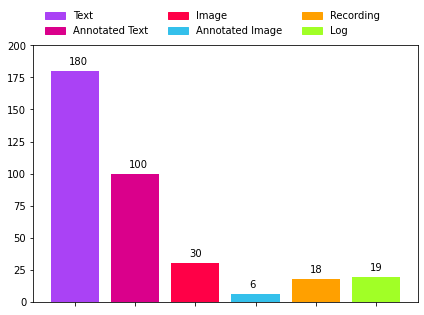

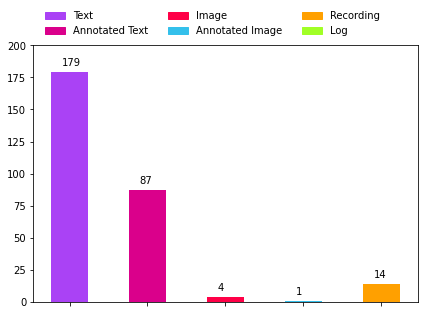

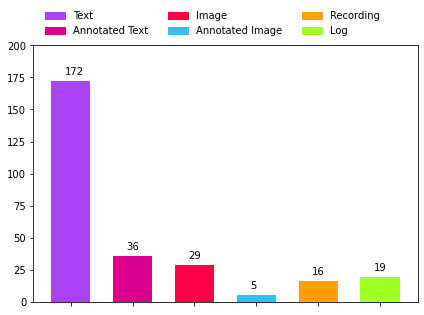

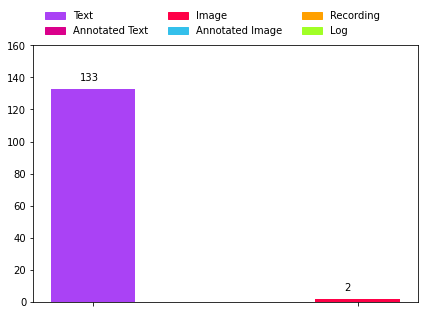

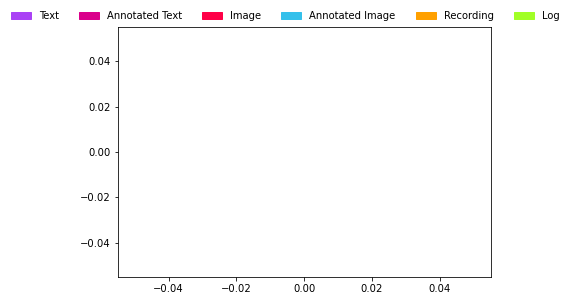

In [15]:
blue ="#34c0eb"
red = "#da008b"
green ="#ff0047"
orange = "#ffa000"
purple = "#a1ff26"
last_color = "#aa42f5"
cs = {
      'how is the information presented? (Image, text, annotated image, video, etc)':False,
      'how is the information presented? (Image, text, annotated image, video, etc).1':False,
      'how is the information presented? (Image, text, annotated image, video, etc).2':False,
      'S2R Type (Image, Annotated Image, Text, Recording)':True,
      'OB Type (Image, Annotated Image, Text, Recording)':True,
      'EB Type (Image, Annotated Image, Text, Recording)':True,
      'Context Type (Image, Annotated Image, Text, Recording)':True
     }

ratios = {
    "text":0,
    "annotated text":0,
    "image":0,
    "annotated image":0,
    "recording":0,
    "logcat":0,
    "none":0
}
for index, row in df.iterrows():
    r = set()
    for i in cs:
        try:
            for j in ast.literal_eval(row[i]):
                r.add(j)
        except:
            if type(row[i]) == type("string"):
                r.add(row[i])
    for i in r:
        ratios[i] += 1
del ratios['none']
for i in list(ratios.keys()):
    if ratios[i] == 0:
        del ratios[i]
keys = ratios.keys()

values = ratios.values()

plt.bar(keys, values, color=[last_color,red,green,blue,orange,purple])
plt.xticks(range(len(ratios.keys())),[""]*len(ratios.keys()))

xlocs=[i+.15 for i in range(0,6)]
for i, v in enumerate(values):
    plt.text(xlocs[i] - 0.25, v + 5, str(v))

plt.ylim(0,200)

blue_patch = mpatches.Patch(color=last_color, label='Text')
red_patch = mpatches.Patch(color=red, label='Annotated Text')
green_patch = mpatches.Patch(color=green, label='Image')
orange_patch = mpatches.Patch(color=blue, label='Annotated Image')
purple_patch = mpatches.Patch(color=orange, label='Recording')
last_patch = mpatches.Patch(color=purple, label='Log')
plt.figlegend(handles=[blue_patch,red_patch,green_patch,orange_patch,purple_patch,last_patch],loc='upper center', bbox_to_anchor=(0.5, 1.1),
          fancybox=False, shadow=False, ncol=3, frameon=False)
plt.tight_layout()
plt.savefig("rq2_all.eps",format='eps',bbox_inches='tight')
plt.show()
cs = {
      'how is the information presented? (Image, text, annotated image, video, etc)':False,
      'how is the information presented? (Image, text, annotated image, video, etc).1':False,
      'how is the information presented? (Image, text, annotated image, video, etc).2':False,
      'S2R Type (Image, Annotated Image, Text, Recording)':True
     }
ratios = {
    "text":0,
    "annotated text":0,
    "image":0,
    "annotated image":0,
    "recording":0,
    "logcat":0,
    "none":0
}
for index, row in df.iterrows():
    r = set()
    for i in cs:
        try:
            for j in ast.literal_eval(row[i]):
                if not cs[i]:
                    col = "Type of additional info added (S2R, OB, context, EB)"
                    if str(i[-1]) != ")":
                        col+=str(i[-1])
                    if row[col] == 'S2R':
                        r.add(j)
                else:
                    r.add(j)
        except:
            if type(row[i]) == type("string"):
                r.add(row[i])
    for i in r:
        ratios[i] += 1
del ratios['none']
for i in list(ratios.keys()):
    if ratios[i] == 0:
        del ratios[i]
keys = ratios.keys()

values = ratios.values()

plt.bar(keys, values,  color=[last_color,red,green,blue,orange,purple], width = .48)


plt.xticks(range(len(ratios.keys())),[""]*len(ratios.keys()))

xlocs=[i+.15 for i in range(0,6)]
for i, v in enumerate(values):
    plt.text(xlocs[i] - 0.25, v + 5, str(v))

plt.ylim(0,200)

blue_patch = mpatches.Patch(color=last_color, label='Text')
red_patch = mpatches.Patch(color=red, label='Annotated Text')
green_patch = mpatches.Patch(color=green, label='Image')
orange_patch = mpatches.Patch(color=blue, label='Annotated Image')
purple_patch = mpatches.Patch(color=orange, label='Recording')
last_patch = mpatches.Patch(color=purple, label='Log')
plt.figlegend(handles=[blue_patch,red_patch,green_patch,orange_patch,purple_patch,last_patch],loc='upper center', bbox_to_anchor=(0.5, 1.1),
          fancybox=False, shadow=False, ncol=3, frameon=False)
plt.tight_layout()
plt.savefig("rq2_s2r.eps",format='eps',bbox_inches='tight')
plt.show()
cs = {
      'how is the information presented? (Image, text, annotated image, video, etc)':False,
      'how is the information presented? (Image, text, annotated image, video, etc).1':False,
      'how is the information presented? (Image, text, annotated image, video, etc).2':False,
      'OB Type (Image, Annotated Image, Text, Recording)':True
     }
ratios = {
    "text":0,
    "annotated text":0,
    "image":0,
    "annotated image":0,
    "recording":0,
    "logcat":0,
    "none":0
}
for index, row in df.iterrows():
    r = set()
    for i in cs:
        try:
            for j in ast.literal_eval(row[i]):
                if not cs[i]:
                    col = "Type of additional info added (S2R, OB, context, EB)"
                    if str(i[-1]) != ")":
                        col+=str(i[-1])
                    if row[col] == 'OB':
                        r.add(j)
                else:
                    r.add(j)
        except:
            if type(row[i]) == type("string"):
                r.add(row[i])
    for i in r:
        ratios[i] += 1
del ratios['none']
for i in list(ratios.keys()):
    if ratios[i] == 0:
        del ratios[i]
keys = ratios.keys()

values = ratios.values()
plt.bar(keys, values, color=[last_color,red,green,blue,orange,purple],width = .64)
plt.xticks(range(len(ratios.keys())),[""]*len(ratios.keys()))

xlocs=[i+.15 for i in range(0,6)]
for i, v in enumerate(values):
    plt.text(xlocs[i] - 0.25, v + 5, str(v))

plt.ylim(0,200)


blue_patch = mpatches.Patch(color=last_color, label='Text')
red_patch = mpatches.Patch(color=red, label='Annotated Text')
green_patch = mpatches.Patch(color=green, label='Image')
orange_patch = mpatches.Patch(color=blue, label='Annotated Image')
purple_patch = mpatches.Patch(color=orange, label='Recording')
last_patch = mpatches.Patch(color=purple, label='Log')
plt.figlegend(handles=[blue_patch,red_patch,green_patch,orange_patch,purple_patch,last_patch],loc='upper center', bbox_to_anchor=(0.5, 1.1),
          fancybox=False, shadow=False, ncol=3, frameon=False)
plt.tight_layout()
plt.savefig('rq2_ob.eps',format='eps',bbox_inches='tight')
plt.show()

cs = {
      'how is the information presented? (Image, text, annotated image, video, etc)':False,
      'how is the information presented? (Image, text, annotated image, video, etc).1':False,
      'how is the information presented? (Image, text, annotated image, video, etc).2':False,
      'Context Type (Image, Annotated Image, Text, Recording)':True
     }
ratios = {
    "text":0,
    "annotated text":0,
    "image":0,
    "annotated image":0,
    "recording":0,
    "logcat":0,
    "none":0
}
for index, row in df.iterrows():
    r = set()
    for i in cs:
        try:
            for j in ast.literal_eval(row[i]):
                if not cs[i]:
                    col = "Type of additional info added (S2R, OB, context, EB)"
                    if str(i[-1]) != ")":
                        col+=str(i[-1])
                    if row[col] == 'context':
                        r.add(j)
                else:
                    r.add(j)
        except:
            if type(row[i]) == type("string"):
                r.add(row[i])
    for i in r:
        ratios[i] += 1
for i in list(ratios.keys()):
    if ratios[i] == 0:
        del ratios[i]
del ratios['none']
keys = ratios.keys()

values = ratios.values()

plt.bar(keys, values, color=[last_color,green], width=.32)
plt.xticks(range(len(ratios.keys())),[""]*len(ratios.keys()))

xlocs=[i+.2 for i in range(0,6)]
for i, v in enumerate(values):
    plt.text(xlocs[i] - 0.25, v + 5, str(v))

plt.ylim(0,160)

blue_patch = mpatches.Patch(color=last_color, label='Text')
red_patch = mpatches.Patch(color=red, label='Annotated Text')
green_patch = mpatches.Patch(color=green, label='Image')
orange_patch = mpatches.Patch(color=blue, label='Annotated Image')
purple_patch = mpatches.Patch(color=orange, label='Recording')
last_patch = mpatches.Patch(color=purple, label='Log')
plt.figlegend(handles=[blue_patch,red_patch,green_patch,orange_patch,purple_patch,last_patch],loc='upper center', bbox_to_anchor=(0.5, 1.1),
          fancybox=False, shadow=False, ncol=3, frameon=False)
plt.tight_layout()
plt.savefig('rq2_context.eps', format='eps',bbox_inches='tight')
plt.show()

blue_patch = mpatches.Patch(color=last_color, label='Text')
red_patch = mpatches.Patch(color=red, label='Annotated Text')
green_patch = mpatches.Patch(color=green, label='Image')
orange_patch = mpatches.Patch(color=blue, label='Annotated Image')
purple_patch = mpatches.Patch(color=orange, label='Recording')
last_patch = mpatches.Patch(color=purple, label='Log')
plt.figlegend(handles=[blue_patch,red_patch,green_patch,orange_patch,purple_patch,last_patch],loc='upper center', bbox_to_anchor=(0.5, 1.05),
          fancybox=False, shadow=False, ncol=6, frameon=False)
plt.plot([0],[0])

plt.tight_layout()
plt.savefig('rq2_legend.eps', format='eps',bbox_inches='tight')

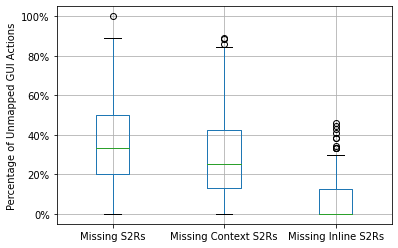

In [12]:
df.boxplot(column=['rq6_ratio','rq6_setup_ratio','rq6_unlinked_ratio'])
yt = [0,.2,.4,.6,.8,1]
plt.yticks(yt,[str(int(x * 100))+"%" for x in yt])
plt.title("")
plt.suptitle("")
plt.xlabel("")
plt.xticks(plt.xticks()[0],['Missing S2Rs','Missing Context S2Rs','Missing Inline S2Rs'])
plt.ylabel("Percentage of Unmapped GUI Actions")
plt.savefig("rq3_box.eps",format='eps')

defaultdict(<class 'int'>, {'OB': 10, 'S2R': 11, 'context': 19, 'EB': 1})


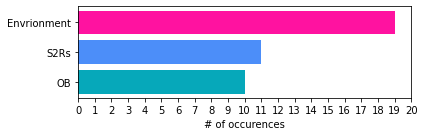

In [13]:
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator


figure(figsize=(6, 2))
cs = {'Type of additional info added (S2R, OB, context, EB)':False,
'Type of additional info added (S2R, OB, context, EB).1':False,
'Type of additional info added (S2R, OB, context, EB).2':False}
ratios = defaultdict(int)
for index, row in df.iterrows():
    r = set()
    for i in cs:
        if str(row[i]) != 'nan':
            r.add(row[i])
    for i in r:
        ratios[i] += 1
del ratios[
    'EB'
]
keys = ['OB','S2Rs','Envrionment']

values = list(ratios.values())
plt.barh(keys, values, color=['#06a8ba','#4c8ef9','#ff12a0'])
plt.xticks(range(21),range(21))
plt.xlabel("# of occurences")
plt.tight_layout()
plt.savefig('rq4_types.eps',format='eps')

0.3521141975308644


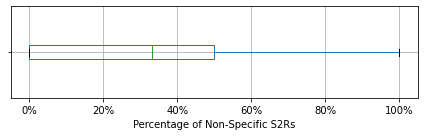

In [14]:
figure(figsize=(6, 2))
df.boxplot(column='rq5_s2r',vert=False)
yt = [0,.2,.4,.6,.8,1]
plt.xticks(yt,[str(int(x * 100))+"%" for x in yt])
plt.yticks(plt.yticks()[0],[""])
plt.xlabel("Percentage of Non-Specific S2Rs")
plt.tight_layout()
plt.savefig('rq5_box.eps',format='eps')
